In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
import PIL.Image as Image
import numpy as np
from typing_extensions import dataclass_transform

# 自定义数据集

In [2]:
import os
from torch.utils.data import DataLoader, Dataset

def download_imgs(train = True):
    path = "train" if train else "test"
    flower_types = os.listdir("./flower/flower_data/" + path)
    images = []
    for type in flower_types:
        flower_fold = "./flower/flower_data/" + path + "/" + type
        flowers = os.listdir(flower_fold)
        for f in flowers:
            with Image.open(flower_fold + "/" + f) as img:
                images.append(img.convert("RGB").copy())
    return images

images = download_imgs()


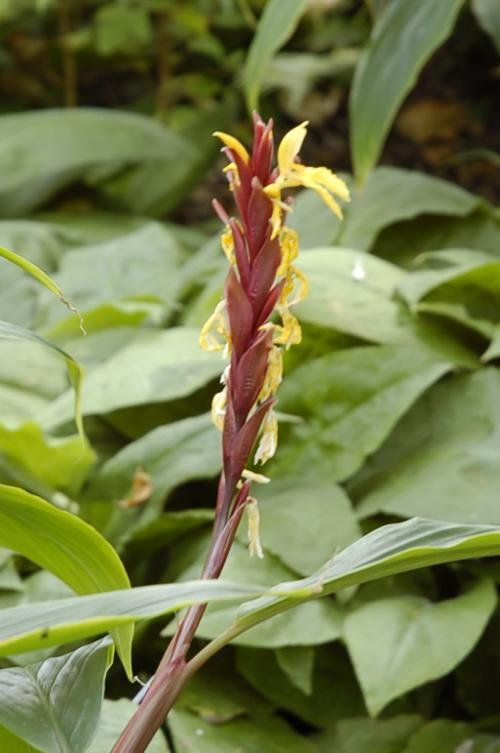

In [4]:
images[0]

In [73]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

res = transform(images[0])
res.shape

torch.Size([3, 64, 64])

In [6]:
class FlowerDataset(Dataset):
    def __init__(self, train_flag=True):
        if train_flag:
            self.transform = transforms.Compose([
                transforms.Resize((64, 64)),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomRotation(30),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406],
                                     [0.229, 0.224, 0.225])
            ])
        else:
            self.transform = transforms.Compose([
                transforms.Resize((64, 64)),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406],
                                     [0.229, 0.224, 0.225])
            ])

        # 只保存路径和标签
        path = "train" if train_flag else "valid"
        flower_types = os.listdir("./flower/flower_data/" + path)
        self.images = []
        for type in flower_types:
            flower_fold = "./flower/flower_data/" + path + "/" + type
            flowers = os.listdir(flower_fold)
            for f in flowers:
                self.images.append((
                    os.path.join(flower_fold, f),  # 保存路径
                    int(type) - 1
                ))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path, label = self.images[idx]
        with Image.open(img_path) as img:
            img = img.convert("RGB")
            if self.transform:
                img = self.transform(img)   # <-- 动态应用 transform
        return img, torch.tensor(label, dtype=torch.long)


In [7]:
train_dataset = FlowerDataset(train_flag=True)
test_dataset = FlowerDataset(train_flag=False)
print(train_dataset.__len__())
print(test_dataset.__len__())

6552
818


In [8]:
train_dataloader = DataLoader(dataset=train_dataset, batch_size=64)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=64)

In [9]:
ele = iter(train_dataloader)
next(ele)[0], next(ele)[1]

(tensor([[[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           ...,
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],
 
          [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           ...,
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],
 
          [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
           [-

In [10]:
class FlowerModel(nn.Module):
    def __init__(self):
        super(FlowerModel, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc1 = nn.Linear(in_features=32 * 16 * 16, out_features=512)
        self.fc2 = nn.Linear(in_features=512, out_features=102)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

In [11]:

model = FlowerModel()
device = torch.device("mps")
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
model.train()
for epoch in range(100):
    running_loss = 0.0
    total = 0
    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        total += inputs.size(0)

    epoch_loss = running_loss / total
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/100], Loss: {epoch_loss:.4f}")


Epoch [10/100], Loss: 4.6073
Epoch [20/100], Loss: 4.5616
Epoch [30/100], Loss: 4.5523
Epoch [40/100], Loss: 4.5778
Epoch [50/100], Loss: 4.5398
Epoch [60/100], Loss: 4.2229
Epoch [70/100], Loss: 3.9333
Epoch [80/100], Loss: 3.3445
Epoch [90/100], Loss: 3.4200
Epoch [100/100], Loss: 3.1322


In [12]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.to(device)
        inputs = inputs.to(device)
        outputs = model(inputs)
        pred = torch.argmax(outputs, dim=1)
        total += labels.size(0)
        correct += (labels == pred).sum()

accuracy = 100 * correct / total
print("accuracy:{}%".format(accuracy))

accuracy:17.237163543701172%


## 采用ImageFolder方法

In [2]:
from torchvision.datasets import ImageFolder

train_dataset = ImageFolder(
    root="./flower/flower_data/train",
    transform=transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(30),
        transforms.ToTensor(),
    ]),
)

In [12]:
type(train_dataset[0]), train_dataset[0][0].shape

(tuple, torch.Size([3, 64, 64]))

In [16]:
data_dir="./flower/flower_data/"
train_dir = data_dir + "train"
valid_dir = data_dir + "valid"

In [28]:
data_transforms ={
    "train": transforms.Compose([
        transforms.RandomRotation(45),#随机旋转
        transforms.CenterCrop(224),#中心剪裁
        transforms.RandomHorizontalFlip(p=0.5),#随机水平翻转
        transforms.RandomVerticalFlip(p=0.5),#随机垂直翻转
        transforms.ColorJitter(brightness=0.2, contrast=0.1, saturation=0.1, hue=0.1), #亮度、对比对、饱和度、色相
        transforms.RandomGrayscale(p=0.025),#概率转成灰度率
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    "valid": transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),#中心剪裁
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
}

In [29]:
batch_size = 8
image_datasets = {
    x: datasets.ImageFolder(data_dir + x, data_transforms[x]) for x in ["train", "valid"]
}
dataloaders = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True) for x in ["train", "valid"]
}
datasizes = {
    x: len(image_datasets[x]) for x in ["train", "valid"]
}

In [30]:
image_datasets, datasizes

({'train': Dataset ImageFolder
      Number of datapoints: 6552
      Root location: ./flower/flower_data/train
      StandardTransform
  Transform: Compose(
                 RandomRotation(degrees=[-45.0, 45.0], interpolation=nearest, expand=False, fill=0)
                 CenterCrop(size=(224, 224))
                 RandomHorizontalFlip(p=0.5)
                 RandomVerticalFlip(p=0.5)
                 ColorJitter(brightness=(0.8, 1.2), contrast=(0.9, 1.1), saturation=(0.9, 1.1), hue=(-0.1, 0.1))
                 RandomGrayscale(p=0.025)
                 ToTensor()
                 Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
             ),
  'valid': Dataset ImageFolder
      Number of datapoints: 818
      Root location: ./flower/flower_data/valid
      StandardTransform
  Transform: Compose(
                 Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
                 CenterCrop(size=(224, 224))
                 ToTensor()
         

In [34]:
class_names = image_datasets['train'].classes

In [35]:
# A mapping of category names to labels
cat_to_name = {"21": "fire lily", "3": "canterbury bells", "45": "bolero deep blue", "1": "pink primrose", "34": "mexican aster", "27": "prince of wales feathers", "7": "moon orchid", "16": "globe-flower", "25": "grape hyacinth", "26": "corn poppy", "79": "toad lily", "39": "siam tulip", "24": "red ginger", "67": "spring crocus", "35": "alpine sea holly", "32": "garden phlox", "10": "globe thistle", "6": "tiger lily", "93": "ball moss", "33": "love in the mist", "9": "monkshood", "102": "blackberry lily", "14": "spear thistle", "19": "balloon flower", "100": "blanket flower", "13": "king protea", "49": "oxeye daisy", "15": "yellow iris", "61": "cautleya spicata", "31": "carnation", "64": "silverbush", "68": "bearded iris", "63": "black-eyed susan", "69": "windflower", "62": "japanese anemone", "20": "giant white arum lily", "38": "great masterwort", "4": "sweet pea", "86": "tree mallow", "101": "trumpet creeper", "42": "daffodil", "22": "pincushion flower", "2": "hard-leaved pocket orchid", "54": "sunflower", "66": "osteospermum", "70": "tree poppy", "85": "desert-rose", "99": "bromelia", "87": "magnolia", "5": "english marigold", "92": "bee balm", "28": "stemless gentian", "97": "mallow", "57": "gaura", "40": "lenten rose", "47": "marigold", "59": "orange dahlia", "48": "buttercup", "55": "pelargonium", "36": "ruby-lipped cattleya", "91": "hippeastrum", "29": "artichoke", "71": "gazania", "90": "canna lily", "18": "peruvian lily", "98": "mexican petunia", "8": "bird of paradise", "30": "sweet william", "17": "purple coneflower", "52": "wild pansy", "84": "columbine", "12": "colt's foot", "11": "snapdragon", "96": "camellia", "23": "fritillary", "50": "common dandelion", "44": "poinsettia", "53": "primula", "72": "azalea", "65": "californian poppy", "80": "anthurium", "76": "morning glory", "37": "cape flower", "56": "bishop of llandaff", "60": "pink-yellow dahlia", "82": "clematis", "58": "geranium", "75": "thorn apple", "41": "barbeton daisy", "95": "bougainvillea", "43": "sword lily", "83": "hibiscus", "78": "lotus lotus", "88": "cyclamen", "94": "foxglove", "81": "frangipani", "74": "rose", "89": "watercress", "73": "water lily", "46": "wallflower", "77": "passion flower", "51": "petunia"}

## 采用vgg模型

In [127]:
import torch.nn as nn
import torch.nn.functional as F

import torchvision.models as models
from torchvision.models import VGG16_Weights
# Load a pre-trained VGG16 model
model = models.vgg16(weights=VGG16_Weights.IMAGENET1K_V1)

for param in model.parameters():
    param.requires_grad = False

# 解冻高层特征或 classifier 高层
for param in model.classifier[0:6].parameters():  # fc1+fc2
    param.requires_grad = True

# 优化器只更新解冻部分
optimizer = torch.optim.Adam(
    list(model.classifier[0:6].parameters()),
    lr=1e-4
)

class MyNetwork(nn.Module):
    def __init__(self, input_size, hidden_units, drop_rate, output_size):
        super().__init__()

        self.layer1 = nn.Linear(input_size, hidden_units)
        self.layer2 = nn.Linear(hidden_units, hidden_units // 2)
        self.layer3 = nn.Linear(hidden_units // 2, output_size)
        self.dropout = nn.Dropout(drop_rate)
        self.output = nn.LogSoftmax(dim=1)

    def forward(self, x):
        out = self.layer1(x)
        out = F.relu(out)
        out = self.dropout(out)

        out = self.layer2(out)
        out = F.relu(out)
        out = self.dropout(out)

        out = self.layer3(out)
        out = self.output(out)

        return out

batch_size = 64
epochs = 12
learning_rate = 0.001
criterion = nn.NLLLoss()
device = torch.device("mps")

# Other constants
input_size = 25088
output_size = 102
hidden_layers = 512
drop_rate = 0.2
model.classifier = MyNetwork(input_size, hidden_layers, drop_rate, output_size)

def get_validation(model, device, loaders, criterion):
    loss, accuracy = 0, 0

    model.to(device)

    for images, labels in loaders:
        images, labels = images.to(device), labels.to(device)
        output = model(images)
        loss += criterion(output, labels).detach()*images.size(0)
        ps = torch.exp(output)
        equity = labels == ps.max(dim=1)[1]
        accuracy += equity.type(torch.FloatTensor).mean()

    return loss / len(loaders.dataset), 100 * accuracy / len(loaders)

def train_network():
    trainloader = dataloaders["train"]
    model.to(device)
    optimizer = optim.Adam(model.classifier.parameters(), lr=learning_rate)  # Use Adam optimizer for model's classifier parameters

    for epoch in range(epochs):
        training_loss = 0
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            output = model(images)
            Loss = criterion(output, labels)
            Loss.backward()
            optimizer.step()
            training_loss += Loss.item()

        model.eval()
        with torch.no_grad():
            loss, accuracy = get_validation(model, device, dataloaders["valid"], criterion)

        print(
            f"Epoch: {epoch + 1}/{epochs}\n"
            f"Training Loss: {training_loss / len(dataloaders['train']):.4f}\n"
            f"Validation Loss: {loss / len(dataloaders['valid']):.4f}\n"
            f"Validation Accuracy: {accuracy:.2f}%\n\n"
        )

        model.train()

    return model

In [129]:
# Trains a neural network and returns the trained model
trained_model = train_network()

Epoch: 1/12
Training Loss: 2.9487
Validation Loss: 0.0153
Validation Accuracy: 58.62%


Epoch: 2/12
Training Loss: 1.9154
Validation Loss: 0.0110
Validation Accuracy: 70.75%


Epoch: 3/12
Training Loss: 1.7008
Validation Loss: 0.0086
Validation Accuracy: 77.31%


Epoch: 4/12
Training Loss: 1.5991
Validation Loss: 0.0074
Validation Accuracy: 79.61%


Epoch: 5/12
Training Loss: 1.5051
Validation Loss: 0.0074
Validation Accuracy: 79.85%


Epoch: 6/12
Training Loss: 1.4416
Validation Loss: 0.0070
Validation Accuracy: 79.73%


Epoch: 7/12
Training Loss: 1.4091
Validation Loss: 0.0072
Validation Accuracy: 80.95%


Epoch: 8/12
Training Loss: 1.4023
Validation Loss: 0.0081
Validation Accuracy: 77.79%


Epoch: 9/12
Training Loss: 1.4046
Validation Loss: 0.0069
Validation Accuracy: 80.70%


Epoch: 10/12
Training Loss: 1.3520
Validation Loss: 0.0072
Validation Accuracy: 82.16%


Epoch: 11/12
Training Loss: 1.3298
Validation Loss: 0.0073
Validation Accuracy: 80.95%


Epoch: 12/12
Training Loss: 1.

## 图像还原显示

In [43]:

def im_convert(tensor):
    device = torch.device("mps")
    image = tensor.to(device).clone().detach()
    image = image.cpu().numpy().squeeze()
    image = image.transpose(1, 2, 0)
    image = image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    image = image.clip(0, 1)
    return image

tensor([ 9, 38, 90, 62,  3, 61, 18, 97])


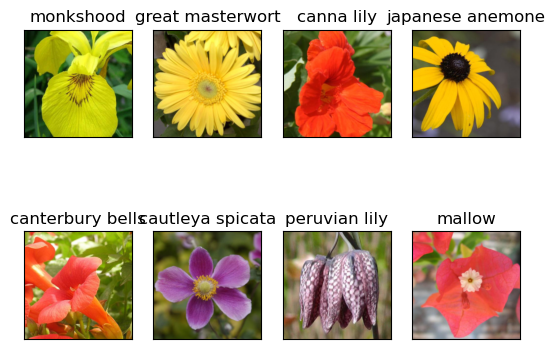

In [45]:
import matplotlib.pyplot as plt
fig = plt.figure()
columns = 4
rows = 2

dataiter = iter(dataloaders['valid'])
inputs, classes = next(dataiter)
print(classes)
for idx in range(columns * rows):
    ax = fig.add_subplot(rows, columns, idx+1, xticks=[], yticks=[])
    ax.set_title(cat_to_name[str(int(classes[idx]))])
    plt.imshow(im_convert(inputs[idx]))
plt.show()


# 采用resnet网络

In [99]:

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torchvision.models import ResNet152_Weights
from torchvision import transforms
from torch.optim.lr_scheduler import StepLR

data_transforms = {
    "train": transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    "valid": transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
}

batch_size = 8
image_datasets = {
    x: datasets.ImageFolder(data_dir + x, data_transforms[x]) for x in ["train", "valid"]
}
dataloaders = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True) for x in ["train", "valid"]
}
datasizes = {
    x: len(image_datasets[x]) for x in ["train", "valid"]
}

# 加载预训练模型
resnet = models.resnet152(weights=ResNet152_Weights.IMAGENET1K_V1)

# 冻结特征提取层
for param in resnet.parameters():
    param.requires_grad = False
for param in resnet.layer4.parameters():
    param.requires_grad = True

# 替换分类头
input_size = resnet.fc.in_features
output_size = 102
drop_rate = 0.1
resnet.fc = nn.Sequential(
    nn.Linear(input_size, 512),
    nn.ReLU(),
    nn.Dropout(p=drop_rate),
    nn.Linear(512, output_size),
    nn.LogSoftmax(dim=1)
)

criterion = nn.NLLLoss()
epochs = 10
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

resnet.to(device)

optimizer = optim.Adam(
    list(resnet.fc.parameters()) + list(resnet.layer4.parameters()),
    lr=1e-4)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

train_loader = dataloaders["train"]
valid_loader = dataloaders["valid"]

for epoch in range(epochs):
    resnet.train()
    running_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        output = resnet(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    resnet.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)
            output = resnet(images)
            loss = criterion(output, labels)
            val_loss += loss.item()
            preds = torch.argmax(output, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    accuracy = correct / total

    print(
        f"Epoch [{epoch+1}/{epochs}]: "
        f"Train Loss: {running_loss / len(train_loader):.4f} | "
        f"Valid Loss: {val_loss / len(valid_loader):.4f} | "
        f"Accuracy: {accuracy * 100:.2f}%"
    )
    scheduler.step()


Epoch [1/10]: Train Loss: 2.5001 | Valid Loss: 0.5374 | Accuracy: 86.31%
Epoch [2/10]: Train Loss: 0.9714 | Valid Loss: 0.2075 | Accuracy: 94.25%
Epoch [3/10]: Train Loss: 0.6480 | Valid Loss: 0.1628 | Accuracy: 96.33%
Epoch [4/10]: Train Loss: 0.5145 | Valid Loss: 0.1563 | Accuracy: 96.58%
Epoch [5/10]: Train Loss: 0.4421 | Valid Loss: 0.1170 | Accuracy: 97.19%
Epoch [6/10]: Train Loss: 0.2906 | Valid Loss: 0.0928 | Accuracy: 98.29%
Epoch [7/10]: Train Loss: 0.2711 | Valid Loss: 0.0871 | Accuracy: 98.04%
Epoch [8/10]: Train Loss: 0.2347 | Valid Loss: 0.0868 | Accuracy: 98.04%
Epoch [9/10]: Train Loss: 0.2361 | Valid Loss: 0.0899 | Accuracy: 98.29%
Epoch [10/10]: Train Loss: 0.2128 | Valid Loss: 0.0850 | Accuracy: 97.92%


In [101]:
model.state_dict()

odict_keys(['features.0.weight', 'features.0.bias', 'features.2.weight', 'features.2.bias', 'features.5.weight', 'features.5.bias', 'features.7.weight', 'features.7.bias', 'features.10.weight', 'features.10.bias', 'features.12.weight', 'features.12.bias', 'features.14.weight', 'features.14.bias', 'features.17.weight', 'features.17.bias', 'features.19.weight', 'features.19.bias', 'features.21.weight', 'features.21.bias', 'features.24.weight', 'features.24.bias', 'features.26.weight', 'features.26.bias', 'features.28.weight', 'features.28.bias', 'classifier.0.weight', 'classifier.0.bias', 'classifier.3.weight', 'classifier.3.bias', 'classifier.6.weight', 'classifier.6.bias'])

In [103]:
optimizer.state_dict().keys()

dict_keys(['state', 'param_groups'])

In [104]:
torch.save(resnet.state_dict(), "resnet_hbj.pth")

In [117]:
new_resnet = models.resnet152(weights=ResNet152_Weights.IMAGENET1K_V1)
new_resnet.fc = nn.Sequential(
    nn.Linear(input_size, 512),
    nn.ReLU(),
    nn.Dropout(p=drop_rate),
    nn.Linear(512, output_size),
    nn.LogSoftmax(dim=1)
)
resnet_state_dict = torch.load("resnet_hbj.pth")
new_resnet.load_state_dict(resnet_state_dict)

<All keys matched successfully>

In [130]:
it = iter(dataloaders["valid"])
test_o = next(it)

In [131]:
new_resnet.eval()
with torch.no_grad():
    output = new_resnet(test_o[0])
    preds = torch.argmax(output, dim=1)
    print("预测的值:", preds)
    for p, y_true in zip(preds, test_o[1]):
        print(f"预测的类别:{p} {cat_to_name[str(p.item())]}, 真实类别:{y_true} {cat_to_name[str(y_true.item())]}")

预测的值: tensor([38, 12,  7,  7, 63, 41, 29, 68])
预测的类别:38 great masterwort, 真实类别:52 wild pansy
预测的类别:12 colt's foot, 真实类别:12 colt's foot
预测的类别:7 moon orchid, 真实类别:29 artichoke
预测的类别:7 moon orchid, 真实类别:7 moon orchid
预测的类别:63 black-eyed susan, 真实类别:63 black-eyed susan
预测的类别:41 barbeton daisy, 真实类别:41 barbeton daisy
预测的类别:29 artichoke, 真实类别:29 artichoke
预测的类别:68 bearded iris, 真实类别:68 bearded iris


In [132]:
model2 = models.vgg16(weights=VGG16_Weights.IMAGENET1K_V1)

In [135]:
model2.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [137]:
model2.classifier[0:6]

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
)